In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import time

import data_splitter as ds
import data_loader as dl
import run_model as rm
import eval_model as ev

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
KERASTUNER_TUNER_ID="chief"
KERASTUNER_ORACLE_IP="127.0.0.1"
KERASTUNER_ORACLE_PORT="8000"

In [6]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [7]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [8]:
metadata = pd.read_csv('train.csv')

# Trasfer learning from ImageNet

### Image Resolution 512 x 512

In [9]:
IMG_SIZE = (512, 512, 1)

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

                                                                                                  
 conv2d_10 (Conv2D)             (None, 61, 61, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 61, 61, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
          

                                                                  'activation_14[0][0]',          
                                                                  'activation_17[0][0]',          
                                                                  'activation_18[0][0]']          
                                                                                                  
 conv2d_22 (Conv2D)             (None, 61, 61, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 61, 61, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 61, 61, 64)   0           ['batch_normalization_22[0][0]'] 
          

 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 30, 30, 96)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 30, 30, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 30, 30, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
          

 activation_39 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_39[0][0]'] 
                                                                                                  
 mixed4 (Concatenate)           (None, 30, 30, 768)  0           ['activation_30[0][0]',          
                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 30, 30, 160)  480        ['conv2d_44[0][0]']              
 ormalizat

                                                                  'activation_49[0][0]']          
                                                                                                  
 conv2d_54 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 30, 30, 160)  480        ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 30, 30, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 30, 30, 160)  179200      ['activation_54[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_64 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_64[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 30, 30, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_65[0][0]'] 
          

                                                                                                  
 batch_normalization_73 (BatchN  (None, 30, 30, 192)  576        ['conv2d_73[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_73 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 30, 30, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_nor

 batch_normalization_83 (BatchN  (None, 14, 14, 384)  1152       ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_84 (Conv2D)             (None, 14, 14, 192)  245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_76 (BatchN  (None, 14, 14, 320)  960        ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 activation_87 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 activation_88 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_88[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_nor

In [10]:
# base_model.summary()
keras.utils.plot_model(inception, show_shapes=True)

In [10]:
train_img_ids = cv_img[0]['train']
val_img_ids = cv_img[0]['validate']

In [11]:
BATCH_SIZE = 4*32 
IMG_SIZE = (512, 512, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [12]:
print(len(train_gen), len(val_gen))

218 54


In [13]:
X, y = train_gen[0]
print(X.shape, y.shape)

(128, 512, 512, 3) (128,)


In [14]:
inception.output.shape[-3:]

TensorShape([14, 14, 2048])

## Use initial bias and class weight

In [19]:
%load_ext tensorboard

In [20]:
from keras.callbacks import TensorBoard
import os

log_basepath = '../logs_'
model_name = 'imagenet_512_bias_weight_sgd-lr-default'

model_log_path = log_basepath + model_name
os.makedirs(model_log_path, exist_ok=True)

tensorboard = TensorBoard(
    log_dir=model_log_path,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch'
)

In [13]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
initial_bias = np.log([pos/neg])
print(initial_bias)

[-3.83388407]


In [15]:
initial_bias = tf.keras.initializers.Constant()

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias)
])

model_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [16]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [17]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-07 23:56:11.429249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4546 - tp: 269.0000 - fp: 12019.0000 - tn: 15305.0000 - fn: 311.0000 - accuracy: 0.5581 - precision: 0.0219 - recall: 0.4638 - auc: 0.5089 - prc: 0.0219

2023-04-08 00:07:16.555375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.56465, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-01-prc0.02-tp3.0-loss0.56.hdf5
218/218 [==============================] - 853s 4s/step - loss: 0.4546 - tp: 269.0000 - fp: 12019.0000 - tn: 15305.0000 - fn: 311.0000 - accuracy: 0.5581 - precision: 0.0219 - recall: 0.4638 - auc: 0.5089 - prc: 0.0219 - val_loss: 0.5646 - val_tp: 3.0000 - val_fp: 197.0000 - val_tn: 6575.0000 - val_fn: 137.0000 - val_accuracy: 0.9517 - val_precision: 0.0150 - val_recall: 0.0214 - val_auc: 0.4898 - val_prc: 0.0202
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4556 - tp: 324.0000 - fp: 14140.0000 - tn: 13184.0000 - fn: 256.0000 - accuracy: 0.4841 - precision: 0.0224 - recall: 0.5586 - auc: 0.5155 - prc: 0.0214
Epoch 2: val_loss improved from 0.56465 to 0.47172, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-02-prc0.02-tp0.0-loss0.47.hdf5
218/218 

218/218 [==============================] - 875s 4s/step - loss: 0.4624 - tp: 301.0000 - fp: 14035.0000 - tn: 13291.0000 - fn: 277.0000 - accuracy: 0.4871 - precision: 0.0210 - recall: 0.5208 - auc: 0.5042 - prc: 0.0214 - val_loss: 0.3872 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6770.0000 - val_fn: 142.0000 - val_accuracy: 0.9795 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4938 - val_prc: 0.0203
Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4648 - tp: 289.0000 - fp: 14431.0000 - tn: 12895.0000 - fn: 289.0000 - accuracy: 0.4725 - precision: 0.0196 - recall: 0.5000 - auc: 0.4738 - prc: 0.0189
Epoch 13: val_loss did not improve from 0.38315
218/218 [==============================] - 846s 4s/step - loss: 0.4648 - tp: 289.0000 - fp: 14431.0000 - tn: 12895.0000 - fn: 289.0000 - accuracy: 0.4725 - precision: 0.0196 - recall: 0.5000 - auc: 0.4738 - prc: 0.0189 - val_loss: 0.6650 - val_tp: 50.0000 - val_fp: 2466.0000 - val_tn: 4304.000

In [18]:
model.load_weights('../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-17-prc0.02-tp0.0-loss0.28.hdf5')

In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-08 21:09:07.554349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4743 - tp: 308.0000 - fp: 14028.0000 - tn: 13296.0000 - fn: 272.0000 - accuracy: 0.4875 - precision: 0.0215 - recall: 0.5310 - auc: 0.5025 - prc: 0.0205

2023-04-08 21:30:22.426046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.69250, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-01-prc0.02-tp68.0-loss0.69.hdf5
218/218 [==============================] - 1638s 7s/step - loss: 0.4743 - tp: 308.0000 - fp: 14028.0000 - tn: 13296.0000 - fn: 272.0000 - accuracy: 0.4875 - precision: 0.0215 - recall: 0.5310 - auc: 0.5025 - prc: 0.0205 - val_loss: 0.6925 - val_tp: 68.0000 - val_fp: 3365.0000 - val_tn: 3403.0000 - val_fn: 76.0000 - val_accuracy: 0.5022 - val_precision: 0.0198 - val_recall: 0.4722 - val_auc: 0.4904 - val_prc: 0.0213
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4574 - tp: 285.0000 - fp: 13923.0000 - tn: 13403.0000 - fn: 293.0000 - accuracy: 0.4905 - precision: 0.0201 - recall: 0.4931 - auc: 0.4913 - prc: 0.0208
Epoch 2: val_loss improved from 0.69250 to 0.63348, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-02-prc0.02-tp36.0-loss0.63.hdf5
218/

Epoch 12/100
218/218 [==============================] - ETA: 0s - loss: 0.4621 - tp: 255.0000 - fp: 13057.0000 - tn: 14270.0000 - fn: 322.0000 - accuracy: 0.5205 - precision: 0.0192 - recall: 0.4419 - auc: 0.4801 - prc: 0.0195
Epoch 12: val_loss did not improve from 0.38814
218/218 [==============================] - 1600s 7s/step - loss: 0.4621 - tp: 255.0000 - fp: 13057.0000 - tn: 14270.0000 - fn: 322.0000 - accuracy: 0.5205 - precision: 0.0192 - recall: 0.4419 - auc: 0.4801 - prc: 0.0195 - val_loss: 0.4694 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6770.0000 - val_fn: 142.0000 - val_accuracy: 0.9795 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4950 - val_prc: 0.0204
Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4706 - tp: 280.0000 - fp: 13800.0000 - tn: 13527.0000 - fn: 297.0000 - accuracy: 0.4948 - precision: 0.0199 - recall: 0.4853 - auc: 0.4908 - prc: 0.0198
Epoch 13: val_loss did not improve from 0.38814
218/218 [=========

Epoch 24/100
218/218 [==============================] - ETA: 0s - loss: 0.4709 - tp: 308.0000 - fp: 15436.0000 - tn: 11889.0000 - fn: 271.0000 - accuracy: 0.4371 - precision: 0.0196 - recall: 0.5320 - auc: 0.4846 - prc: 0.0200
Epoch 24: val_loss did not improve from 0.37637
218/218 [==============================] - 1600s 7s/step - loss: 0.4709 - tp: 308.0000 - fp: 15436.0000 - tn: 11889.0000 - fn: 271.0000 - accuracy: 0.4371 - precision: 0.0196 - recall: 0.5320 - auc: 0.4846 - prc: 0.0200 - val_loss: 0.4833 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 6767.0000 - val_fn: 144.0000 - val_accuracy: 0.9790 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4893 - val_prc: 0.0204
Epoch 25/100
218/218 [==============================] - ETA: 0s - loss: 0.4682 - tp: 280.0000 - fp: 13032.0000 - tn: 14294.0000 - fn: 298.0000 - accuracy: 0.5223 - precision: 0.0210 - recall: 0.4844 - auc: 0.5020 - prc: 0.0210
Epoch 25: val_loss improved from 0.37637 to 0.31362, saving model to m

In [18]:
model.load_weights('../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-17-prc0.02-tp0.0-loss0.28.hdf5')

In [21]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint, tensorboard],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-10 00:26:22.962340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]
2023-04-10 00:27:01.051677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


218/218 [==============================] - ETA: 0s - loss: 0.4655 - tp: 292.0000 - fp: 12764.0000 - tn: 14561.0000 - fn: 287.0000 - accuracy: 0.5323 - precision: 0.0224 - recall: 0.5043 - auc: 0.5144 - prc: 0.0215

2023-04-10 00:35:50.379026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.69153, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-01-prc0.02-tp67.0-loss0.69.hdf5
218/218 [==============================] - 852s 4s/step - loss: 0.4655 - tp: 292.0000 - fp: 12764.0000 - tn: 14561.0000 - fn: 287.0000 - accuracy: 0.5323 - precision: 0.0224 - recall: 0.5043 - auc: 0.5144 - prc: 0.0215 - val_loss: 0.6915 - val_tp: 67.0000 - val_fp: 3325.0000 - val_tn: 3443.0000 - val_fn: 77.0000 - val_accuracy: 0.5078 - val_precision: 0.0198 - val_recall: 0.4653 - val_auc: 0.4885 - val_prc: 0.0210
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4791 - tp: 288.0000 - fp: 13536.0000 - tn: 13788.0000 - fn: 292.0000 - accuracy: 0.5044 - precision: 0.0208 - recall: 0.4966 - auc: 0.4936 - prc: 0.0198
Epoch 2: val_loss improved from 0.69153 to 0.59020, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_sgd-lr-default-02-prc0.02-tp11.0-loss0.59.hdf5
218/2

Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4689 - tp: 259.0000 - fp: 12669.0000 - tn: 14659.0000 - fn: 317.0000 - accuracy: 0.5346 - precision: 0.0200 - recall: 0.4497 - auc: 0.4868 - prc: 0.0194
Epoch 13: val_loss did not improve from 0.28753
218/218 [==============================] - 817s 4s/step - loss: 0.4689 - tp: 259.0000 - fp: 12669.0000 - tn: 14659.0000 - fn: 317.0000 - accuracy: 0.5346 - precision: 0.0200 - recall: 0.4497 - auc: 0.4868 - prc: 0.0194 - val_loss: 0.4896 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 6769.0000 - val_fn: 142.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4872 - val_prc: 0.0200
>>> Training time:  10747.577605962753


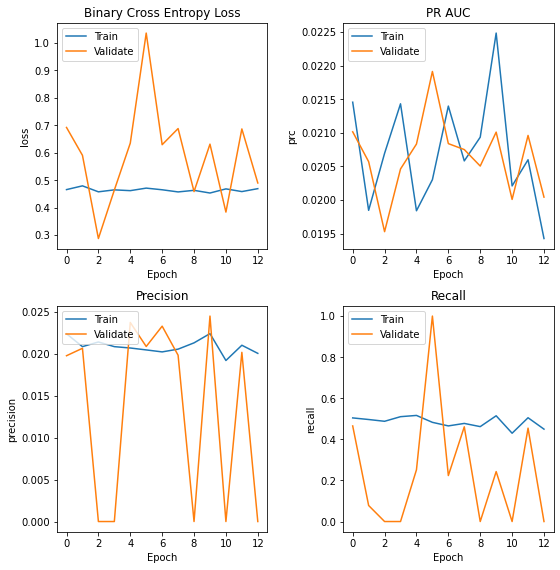

In [24]:
ev.plot_history(history)

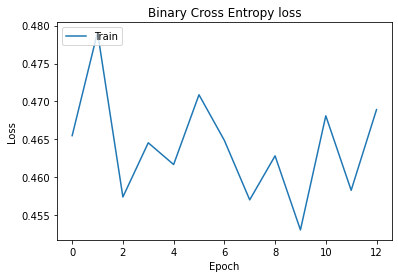

In [25]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Decrease learning rate

In [26]:
LEARNING_RATE = 0.00001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sdg'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sdg
---Checkpoint folder created:  models/inception_imagenet_checkpoint/sdg
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [27]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_sgd-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-10 03:51:59.716102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4387 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4913 - prc: 0.0203

2023-04-10 04:01:20.634715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.49334, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_sgd-lr1e-5-01-prc0.02-tp0.0-loss0.49.hdf5
218/218 [==============================] - 843s 4s/step - loss: 0.4387 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4913 - prc: 0.0203 - val_loss: 0.4933 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 6768.0000 - val_fn: 143.0000 - val_accuracy: 0.9792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4890 - val_prc: 0.0204
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4398 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5030 - prc: 0.0209
Epoch 2: val_loss did not improve from 0.49334
218/218 [==============================] - 827s 4s/step - loss: 0.4398 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn:

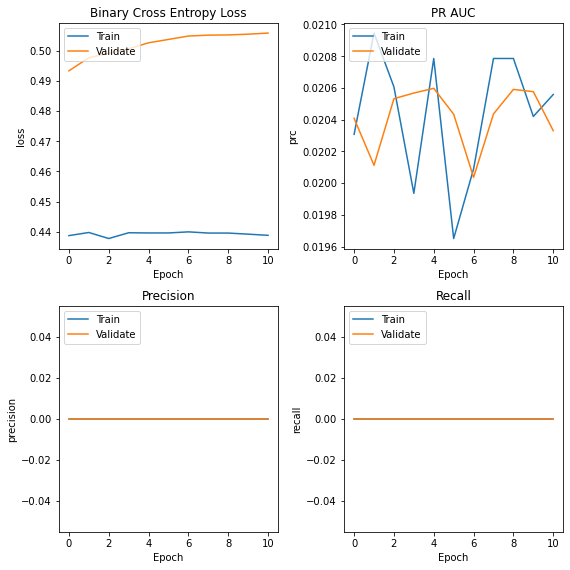

In [28]:
ev.plot_history(history)

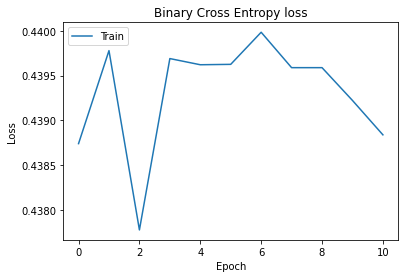

In [29]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Increased learning rate

In [30]:
LEARNING_RATE = 0.01
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [31]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_sgd-lr1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-10 06:31:45.946962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4580 - tp: 290.0000 - fp: 12513.0000 - tn: 21581.0000 - fn: 432.0000 - accuracy: 0.6282 - precision: 0.0227 - recall: 0.4017 - auc: 0.5199 - prc: 0.0220

2023-04-10 06:41:11.857323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.30876, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_sgd-lr1e-2-01-prc0.02-tp0.0-loss0.31.hdf5
218/218 [==============================] - 845s 4s/step - loss: 0.4580 - tp: 290.0000 - fp: 12513.0000 - tn: 21581.0000 - fn: 432.0000 - accuracy: 0.6282 - precision: 0.0227 - recall: 0.4017 - auc: 0.5199 - prc: 0.0220 - val_loss: 0.3088 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4909 - val_prc: 0.0202
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4680 - tp: 298.0000 - fp: 14166.0000 - tn: 13158.0000 - fn: 282.0000 - accuracy: 0.4822 - precision: 0.0206 - recall: 0.5138 - auc: 0.4932 - prc: 0.0203
Epoch 2: val_loss did not improve from 0.30876
218/218 [==============================] - 819s 4s/step - loss: 0.4680 - tp: 298.0000 - fp: 14166.0000 - tn: 13158.0000 - fn: 

Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4773 - tp: 292.0000 - fp: 14300.0000 - tn: 13026.0000 - fn: 286.0000 - accuracy: 0.4773 - precision: 0.0200 - recall: 0.5052 - auc: 0.4890 - prc: 0.0198
Epoch 13: val_loss did not improve from 0.29371
218/218 [==============================] - 853s 4s/step - loss: 0.4773 - tp: 292.0000 - fp: 14300.0000 - tn: 13026.0000 - fn: 286.0000 - accuracy: 0.4773 - precision: 0.0200 - recall: 0.5052 - auc: 0.4890 - prc: 0.0198 - val_loss: 0.6095 - val_tp: 22.0000 - val_fp: 898.0000 - val_tn: 5870.0000 - val_fn: 122.0000 - val_accuracy: 0.8524 - val_precision: 0.0239 - val_recall: 0.1528 - val_auc: 0.4905 - val_prc: 0.0210
Epoch 14/100
218/218 [==============================] - ETA: 0s - loss: 0.4659 - tp: 269.0000 - fp: 13811.0000 - tn: 13515.0000 - fn: 309.0000 - accuracy: 0.4940 - precision: 0.0191 - recall: 0.4654 - auc: 0.4855 - prc: 0.0201
Epoch 14: val_loss did not improve from 0.29371
218/218 [=======================

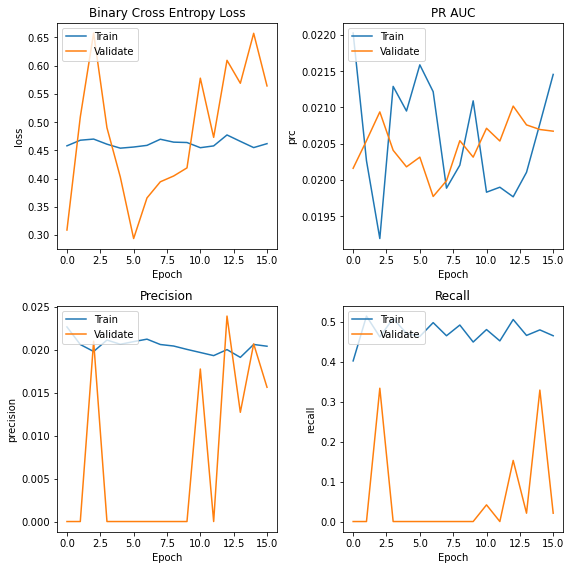

In [32]:
ev.plot_history(history)

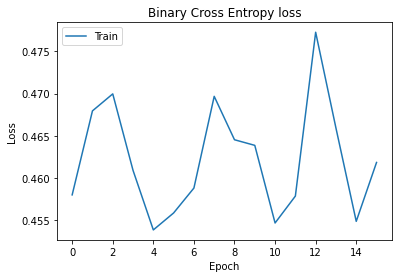

In [33]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Try learning rate 0.0001

In [ ]:
LEARNING_RATE = 0.0001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

In [34]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_sgd-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-10 10:28:16.557570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4644 - tp: 278.0000 - fp: 13674.0000 - tn: 13650.0000 - fn: 302.0000 - accuracy: 0.4991 - precision: 0.0199 - recall: 0.4793 - auc: 0.4967 - prc: 0.0207

2023-04-10 10:37:52.139090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.49859, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_sgd-lr1e-4-01-prc0.02-tp0.0-loss0.50.hdf5
218/218 [==============================] - 858s 4s/step - loss: 0.4644 - tp: 278.0000 - fp: 13674.0000 - tn: 13650.0000 - fn: 302.0000 - accuracy: 0.4991 - precision: 0.0199 - recall: 0.4793 - auc: 0.4967 - prc: 0.0207 - val_loss: 0.4986 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 6768.0000 - val_fn: 143.0000 - val_accuracy: 0.9792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4873 - val_prc: 0.0202
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4593 - tp: 317.0000 - fp: 13763.0000 - tn: 13561.0000 - fn: 263.0000 - accuracy: 0.4973 - precision: 0.0225 - recall: 0.5466 - auc: 0.5303 - prc: 0.0234
Epoch 2: val_loss improved from 0.49859 to 0.47379, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_sgd-lr1e-4-02-prc0.02-tp0.0-loss0.47.hdf5
218/

218/218 [==============================] - 863s 4s/step - loss: 0.4694 - tp: 281.0000 - fp: 13159.0000 - tn: 14165.0000 - fn: 299.0000 - accuracy: 0.5177 - precision: 0.0209 - recall: 0.4845 - auc: 0.4961 - prc: 0.0203 - val_loss: 0.5378 - val_tp: 1.0000 - val_fp: 44.0000 - val_tn: 6724.0000 - val_fn: 143.0000 - val_accuracy: 0.9729 - val_precision: 0.0222 - val_recall: 0.0069 - val_auc: 0.4908 - val_prc: 0.0206
Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4580 - tp: 280.0000 - fp: 13672.0000 - tn: 13653.0000 - fn: 299.0000 - accuracy: 0.4993 - precision: 0.0201 - recall: 0.4836 - auc: 0.4860 - prc: 0.0196
Epoch 13: val_loss did not improve from 0.25015
218/218 [==============================] - 863s 4s/step - loss: 0.4580 - tp: 280.0000 - fp: 13672.0000 - tn: 13653.0000 - fn: 299.0000 - accuracy: 0.4993 - precision: 0.0201 - recall: 0.4836 - auc: 0.4860 - prc: 0.0196 - val_loss: 0.4021 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6770.0000 - val_fn:

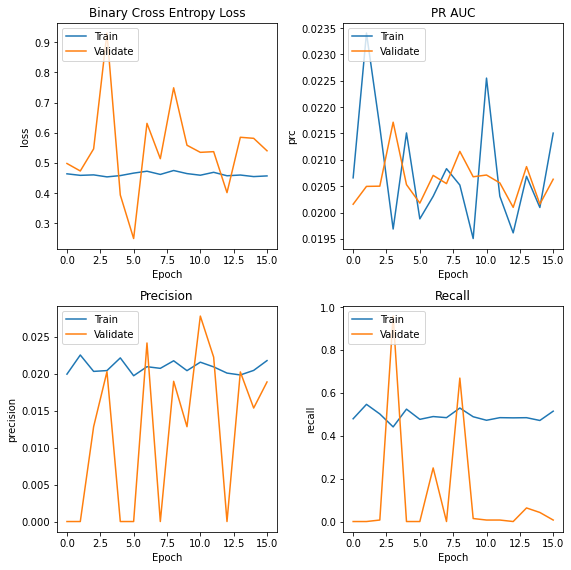

In [35]:
ev.plot_history(history)

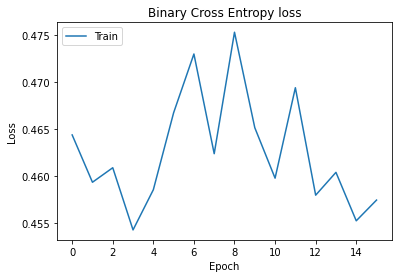

In [36]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()